# Credit Card Fraud with Tensorflow. 
Nathan Brasher - 5.11.20

This notebook examines techniques to improve modeling in the [Kaggle credit card fraud](https://www.kaggle.com/mlg-ulb/creditcardfraud) data set. In developing this model, I borrowed from the examples in [this notebook](https://www.kaggle.com/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets) also stored on Kaggle.

This notebook consists of 3 main sections:
1. EDA
1. Data cleaning and preparation
1. Model fitting
1. Model deployment

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
# Install additional packages for s3 download, SMOTE and tensorflow model
!pip install s3fs keras imblearn tensorflow

In [3]:
# Read project data
df = pd.read_csv('s3://udacity-project-fraud/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


## 1. Exploratory Data Analysis  

Detail TDB...

In [4]:
# The data contains 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Only 0.17% of the data set is fraudulent


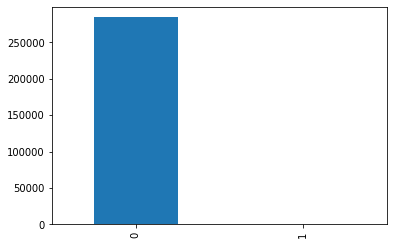

In [5]:
# The data set is heavily imbalanced
print('Only {:.2f}% of the data set is fraudulent'.format(
    100*len(df[df['Class'] == 1]) / len(df)
))

df['Class'].value_counts().plot.bar()
plt.show()

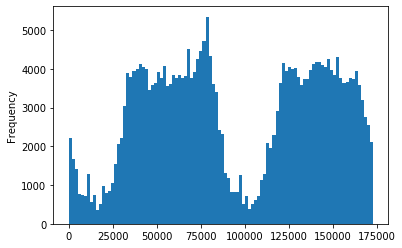

In [6]:
# Transactions are highly cyclical over time
df['Time'].plot.hist(bins=100)
plt.show()

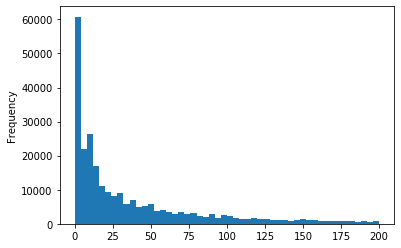

There is a long tail with 28,837 transactions over $200
The maximum transaction is $25,691.16 


In [7]:
# Transaction amount has a long tail with the majority less than $200
df[df['Amount'] < 200]['Amount'].plot.hist(bins=50)
plt.show()

print('There is a long tail with {:,} transactions over $200'.format(
    len(df[df['Amount'] > 200])))
print('The maximum transaction is ${:,.2f} '.format(
    df['Amount'].max()))

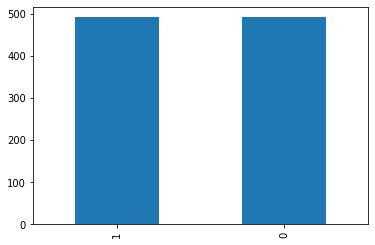

In [8]:
# To compare correlations of features, randomly undersample a balanced dataset
n_fraud = len(df[df['Class'] == 1])

balanced = pd.concat([df[df['Class'] == 1], 
                      df[df['Class'] == 0].sample(n_fraud)], 
                     ignore_index=True)

balanced['Class'].value_counts().plot.bar()
plt.show()

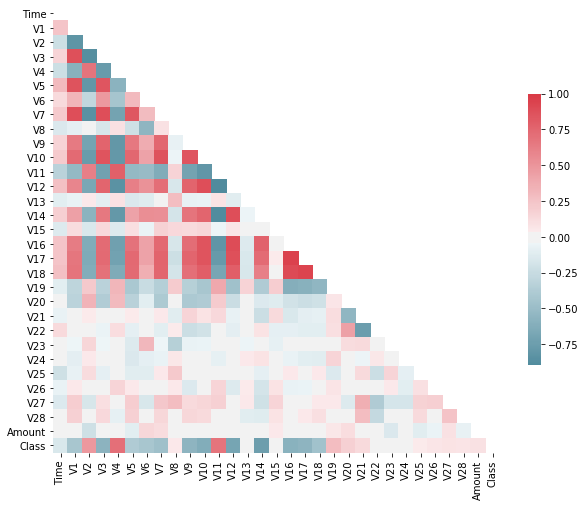

In [9]:
# Compute the correlation matrix
corr = balanced.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10,10))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, cbar_kws={"shrink": .5})
plt.show()

#### Feature distribution
Invetigation of feature distribution indicates that several features appear to be good distinguishers of fraud and non-fraud. In particular V4, V10, V11, V12, V14 and V17 appear to show sharp distinctions - which broadly aligns with the pairwise correlations above.

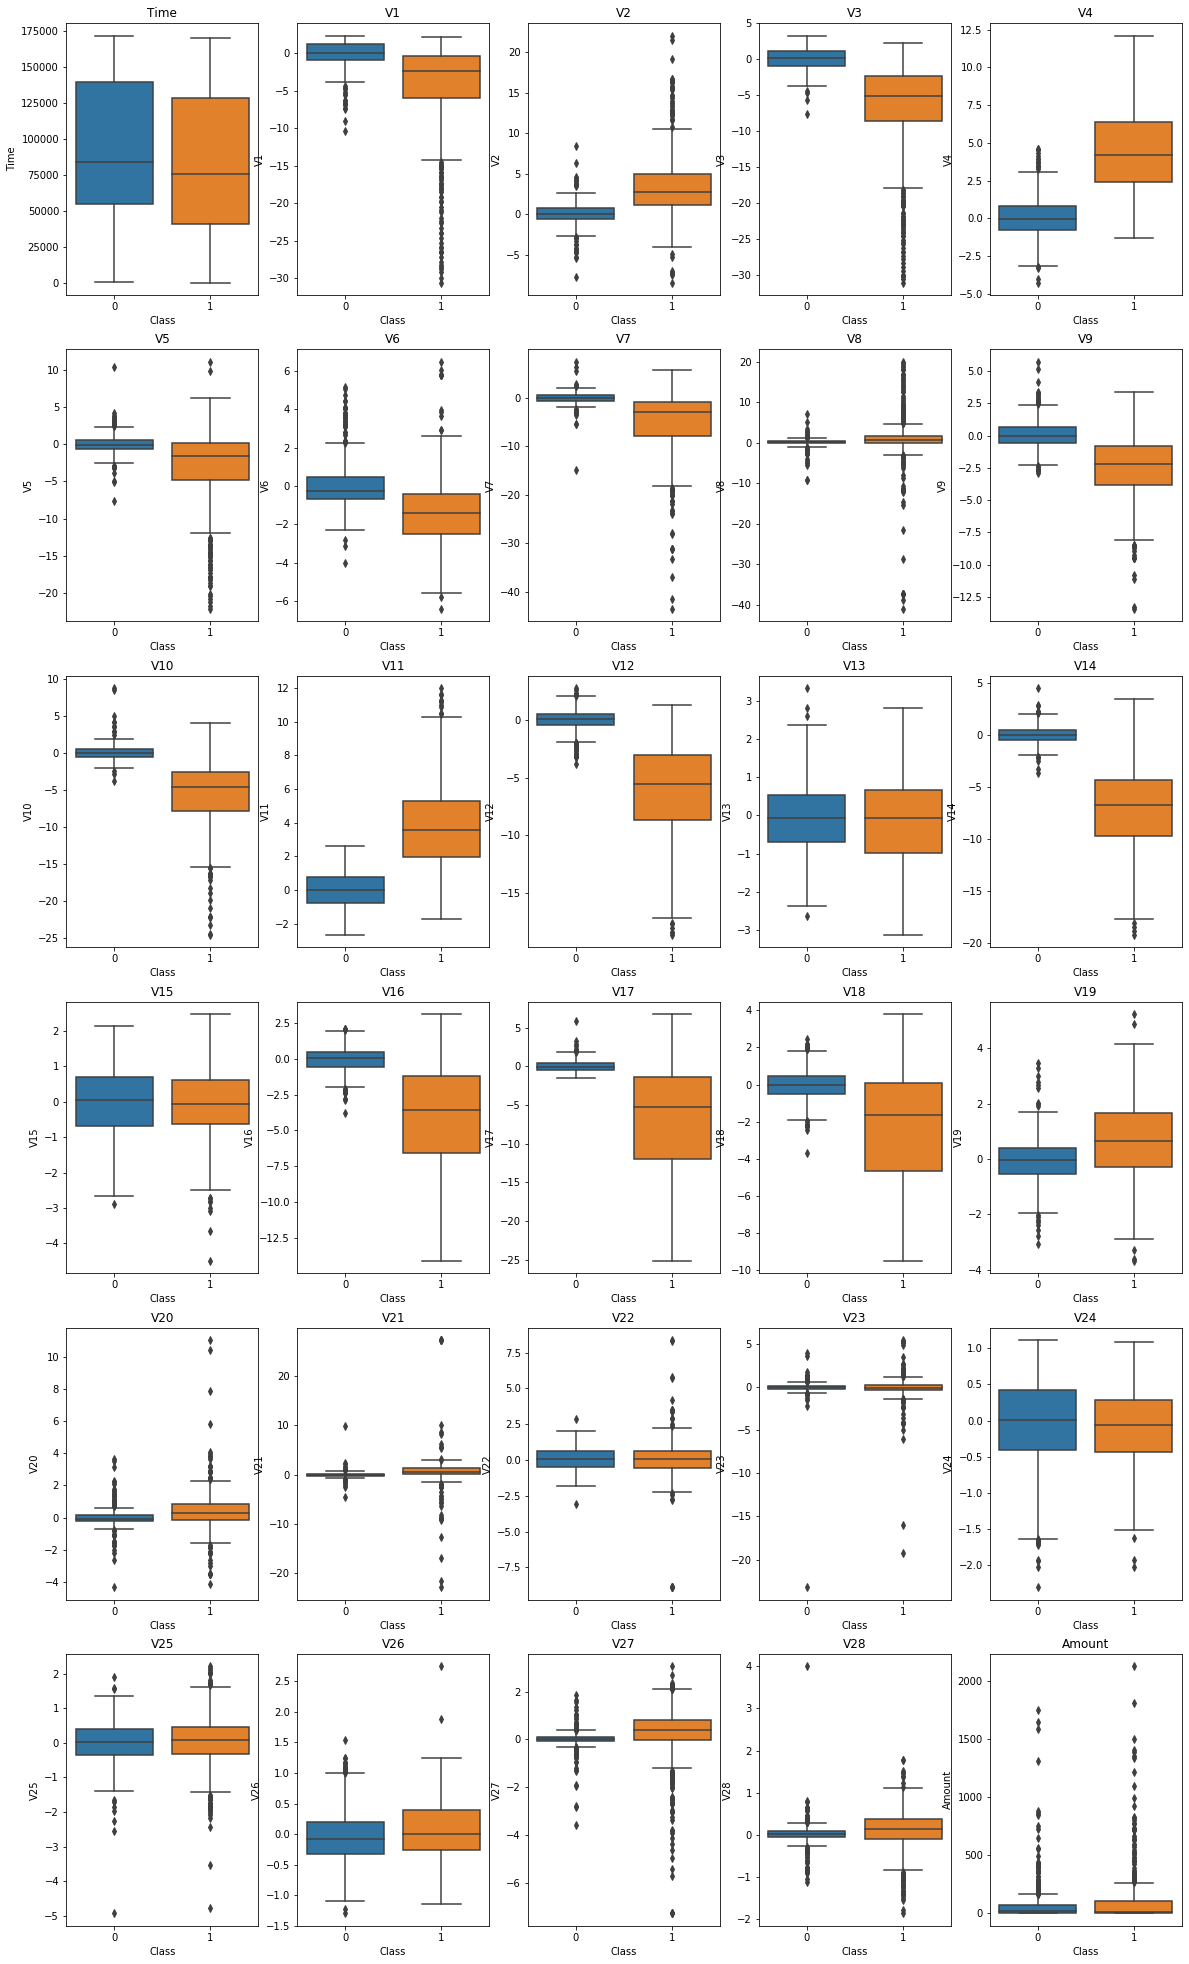

In [10]:
# Check distribution of each feature in fraudulent and non-fraudulent data
feature_cols = balanced.columns.to_list()
feature_cols.remove('Class')

ncols = 5
f, axes = plt.subplots(nrows=(len(feature_cols) // ncols), 
                       ncols=ncols, 
                       figsize=(20, 35))

for i, c in enumerate(feature_cols):
    sns.boxplot(x='Class', y=c, data=balanced, ax=axes[i//ncols, i%ncols])
    axes[i//ncols, i%ncols].set_title(c)

plt.show()

## 2. Data preparation and cleaning. 

From the EDA above, its apparent that each feature has differing scales, and also several outliers depending on the feature. Before running it through the Keras NN inteface, we scale the data using an SKLearn robust scaler to avoid outlier interference.

In [40]:
from sklearn.preprocessing import RobustScaler

rs = RobustScaler()

X = df.drop(['Class'], axis=1)
y = df['Class']

for c in X.columns:
    X[c] = rs.fit_transform(X[c].values.reshape(-1, 1))

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, shuffle=True)

### Outlier removal

From our EDA above V4, 10, 12 and 14 appear to be good distinguishing features between Fraud and non-fraudulent transactions. All of them also have significant outliers (> 1.5 IQR) that could affect predictive power. In order to improve the models ability to distinguish fraud-from non-fraud we want to remove these outlier values

In [53]:
# Remove outliers from train data only
cols_to_clean = ['V4', 'V10', 'V12', 'V14']

fraud = X_train[y_train == 1]

outlier_ix = set()

for c in cols_to_clean:
    q25 = np.percentile(fraud[c].values, 25)
    q75 = np.percentile(fraud[c].values, 75)
    iqr = q75 - q25
    lower_bound, upper_bound = q25 - 1.5*iqr, q75 + 1.5*iqr

    col_outliers = [i for i, v in fraud[c].iteritems() 
                    if v < lower_bound or v > upper_bound]
    outlier_ix.update(col_outliers)
    
print(f'{len(outlier_ix)} points to remove')

X_train_clean = X_train.loc[~X_train.index.isin(outlier_ix), :]
y_train_clean = y_train.loc[~X_train.index.isin(outlier_ix)]

19 points to remove


In [54]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy='minority', random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(X_train_clean, y_train_clean)

# 3. Model Fitting

Testing the above approach with keras and imblearn

In [55]:
import keras
import tensorflow as tf
from keras.layers import Dropout, Dense

model = keras.models.Sequential([
    Dense(X_train.shape[1], input_dim=X_train.shape[1],
          activation='relu'),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.5),
    Dense(8, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile(
    keras.optimizers.Adam(lr=0.005), 
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC()]
)

In [56]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_17 (Dense)             (None, 30)                930       
_________________________________________________________________
dropout_9 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                496       
_________________________________________________________________
dropout_10 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 9         
Total params: 1,571
Trainable params: 1,571
Non-trainable params: 0
____________________________________________________

In [57]:
model.fit(X_train_sm, y_train_sm,
    validation_split=0.2,
    batch_size=5000,
    epochs=20, 
    verbose=1,
)

Train on 363921 samples, validate on 90981 samples
Epoch 1/20
363921/363921 [==============================] - 2s 6us/step - loss: 0.4052 - auc_4: 0.7081 - val_loss: 0.1954 - val_auc_4: 0.8963
Epoch 2/20
363921/363921 [==============================] - 2s 5us/step - loss: 0.1413 - auc_4: 0.9324 - val_loss: 0.1348 - val_auc_4: 0.9532
Epoch 3/20
363921/363921 [==============================] - 2s 5us/step - loss: 0.1022 - auc_4: 0.9636 - val_loss: 0.0796 - val_auc_4: 0.9718
Epoch 4/20
363921/363921 [==============================] - 2s 5us/step - loss: 0.0777 - auc_4: 0.9769 - val_loss: 0.0557 - val_auc_4: 0.9810
Epoch 5/20
363921/363921 [==============================] - 2s 5us/step - loss: 0.0627 - auc_4: 0.9839 - val_loss: 0.0427 - val_auc_4: 0.9862
Epoch 6/20
363921/363921 [==============================] - 2s 5us/step - loss: 0.0560 - auc_4: 0.9879 - val_loss: 0.0361 - val_auc_4: 0.9894
Epoch 7/20
363921/363921 [==============================] - 2s 5us/step - loss: 0.0493 - auc_4: 0

Test Imbalanced AUC: 0.9848068395197134
[[56772    92]
 [   15    83]]


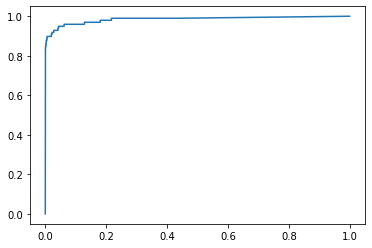

In [58]:
from sklearn import metrics
y_pred = model.predict_classes(X_test)
y_proba = model.predict(X_test)

print(f'Test Imbalanced AUC: {metrics.roc_auc_score(y_test, y_proba)}')

print(metrics.confusion_matrix(y_test, y_pred))

fpr, tpr, _ = metrics.roc_curve(y_test, y_proba)
plt.plot(fpr, tpr)
plt.show()

In [59]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.47      0.85      0.61        98

    accuracy                           1.00     56962
   macro avg       0.74      0.92      0.80     56962
weighted avg       1.00      1.00      1.00     56962

